### 2D Electromagnetic Scattering Simulator using FEM

#### Imports

In [1]:
import calfem.geometry as cfg
import calfem.mesh as cfm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


#### Define Problem
Problem is defined by a series of points connected to form a single surface and the free space wavenumber $k_0$. Furthermore, each line between 2 points can have a reflection boundary (marker=0), source boundary (marker=1) and a open boundary (marker=2). For the example below, we are currently simulating a rectangular waveguide driven at one end and open on the other. 

In [2]:
g = cfg.Geometry()

g.point([0.0, 0.0])
g.point([5.0, 0.0])
g.point([5.0, 1.0])
g.point([0.0, 1.0])

g.spline([0, 1], marker=0)
g.spline([1, 2], marker=1)
g.spline([2, 3], marker=0)
g.spline([3, 0], marker=2)

g.surface([0, 1, 2, 3])

k0 = 10


#### Generate Mesh

For FEM we need to discretize the domain using a triangular mesh. This is done automatically using GMSH, an open source meshing generator. We have control on how coarse or fine to make the mesh through the SizeFactor parameter.

In [3]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset) - 1, dtype="complex")
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem - 1] = key
    return new


In [4]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2
mesh.dofsPerNode = 1
mesh.elSizeFactor = 0.1
coords, edof, dofs, bdofs, elementmarkers = mesh.create()
boundaries = reshape_boundary_dict(bdofs)

for n in range(len(boundaries)):
    if int(boundaries[n]) == 1:
        boundaries[n] = np.sin(coords[n][1] * 2 * np.pi)



Info    : GMSH -> Python-module


C:\Users\Jordan\AppData\Local\Temp\ipykernel_13876\2971730218.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if int(boundaries[n]) == 1:


#### Assemble Element Matrices

To begin the analysis, we must first assemble local matrices for each element which encode how the values at the nodes interact with one another. This formulation comes from the book "Introduction to the Finite Element
Method in Electromagnetics" by Anastasis C. Polycarpou.

In [5]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0, 0]
    x2 = coords[1, 0]
    x3 = coords[2, 0]
    y1 = coords[0, 1]
    y2 = coords[1, 1]
    y3 = coords[2, 1]
    A = 1 / 2 * np.abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2 + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix(
        [[M11, M12, M13], [M12, M22, M23], [M13, M23, M33]], dtype="complex"
    )



In [6]:
def Te(coords, beta):
    x1 = coords[0, 0]
    x2 = coords[1, 0]
    x3 = coords[2, 0]
    y1 = coords[0, 1]
    y2 = coords[1, 1]
    y3 = coords[2, 1]
    A = 1 / 2 * np.abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    T1 = beta * A / 6
    T2 = beta * A / 12
    return np.matrix([[T1, T2, T2], [T2, T1, T2], [T2, T2, T1]], dtype="complex")



In [7]:
def pe(coords, gamma, is_open):
    if not is_open:
        return np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype="complex")
    x1 = coords[0, 0]
    x2 = coords[1, 0]
    y1 = coords[0, 1]
    y2 = coords[1, 1]
    l12 = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    k11 = -gamma * l12 / 3
    k12 = -gamma * l12 / 6
    return np.matrix([[k11, k12, 0], [k12, k11, 0], [0, 0, 0]], dtype="complex")



In [8]:
num_elem = len(edof)
num_nodes = len(dofs)
ke = np.zeros((num_elem, 3, 3), dtype="complex")
be = np.zeros((num_elem, 3), dtype="complex")
for i in range(num_elem):
    is_open = False
    if edof[i][0] <= len(boundaries) and boundaries[edof[i][0] - 1] == 2:
        is_open = True
    ke[i] = (
        Ke(coords[edof[i] - 1], 1, 1)
        + Te(coords[edof[i] - 1], k0 ** 2)
        + pe(coords[edof[i] - 1], 1j * k0, is_open)
    )



#### Assemble Global Matrix

The local element matrices must then be merged together to form the global matrix

In [9]:
K = np.zeros((num_nodes, num_nodes), dtype="complex")
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e, i] - 1, edof[e, j] - 1] += ke[e, i, j]



#### Create RHS Vector

In [10]:
b = np.zeros(num_nodes, dtype=complex)


#### Introduce Boundary Conditions

Once the global matrix is formed, we must the introduce boundary conditions. This involves deleting certain rows and columns and slightly adjusting the right hand side vector.

In [11]:
for n in reversed(range(len(boundaries))):
    if int(np.real(boundaries[n])) == 2:
        continue
    for i in range(len(b)):
        b[i] -= boundaries[n] * K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)


#### Solve

In [12]:
x = np.linalg.solve(K, b)



#### Cleanup Results

In [13]:
abc_i = 0
for i in range(len(boundaries)):
    if boundaries[i] == 2:
        boundaries[i] = x[abc_i]
        abc_i += 1
v = np.concatenate((boundaries, x[abc_i:]))



#### Plot

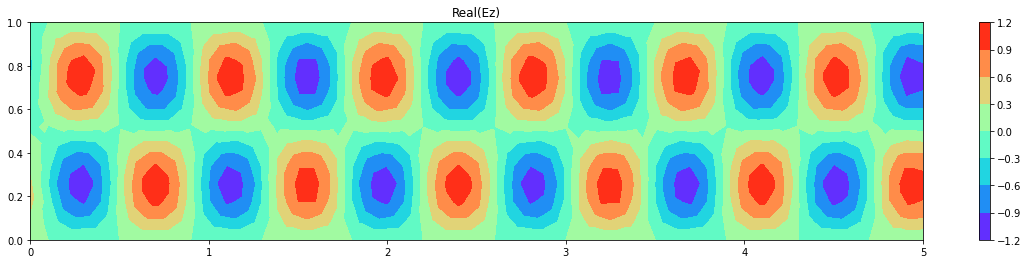

In [14]:
plt.figure(figsize=(20, 4))
plt.tricontourf(coords[:, 0], coords[:, 1], edof - 1, np.real(v), cmap=plt.cm.rainbow)
plt.title("Real(Ez)")
plt.colorbar()

